# Evaluación 1 - Entrenando redes feedforward

**Autores:**

+ Aldo Miguel Arroyo Castro
+ Juan Luis Vicente Bórquez Ormeño

**Correos Electrónicos:**

+ ald.arroyo@duocuc.cl
+ jua.borquez@duocuc.cl

**Fecha de Creación:** Abril de 2025  
**Versión:** 1.0  

---

## Descripción

Este notebook contiene el desarrollo de la evaluación 1 de la asignatura de Deep Learning de la carrera de Ingeniería en Informática de DuocUC sede Concepción.

---

## Requisitos de Software

Este notebook fue desarrollado con Python ...

# Introducción

TODO

# Carga de datos y preprocesamiento de datos

In [1]:
!rm -f train-images-idx3-ubyte.gz train-labels-idx1-ubyte.gz t10k-images-idx3-ubyte.gz t10k-labels-idx1-ubyte.gz

!wget https://storage.googleapis.com/cvdf-datasets/mnist/train-images-idx3-ubyte.gz
!wget https://storage.googleapis.com/cvdf-datasets/mnist/train-labels-idx1-ubyte.gz
!wget https://storage.googleapis.com/cvdf-datasets/mnist/t10k-images-idx3-ubyte.gz
!wget https://storage.googleapis.com/cvdf-datasets/mnist/t10k-labels-idx1-ubyte.gz


--2025-04-18 19:04:06--  https://storage.googleapis.com/cvdf-datasets/mnist/train-images-idx3-ubyte.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.180.207, 142.251.167.207, 142.251.163.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.180.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9912422 (9.5M) [application/x-gzip]
Saving to: ‘train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]   9.45M  26.8MB/s    in 0.4s    

2025-04-18 19:04:07 (26.8 MB/s) - ‘train-images-idx3-ubyte.gz’ saved [9912422/9912422]

--2025-04-18 19:04:08--  https://storage.googleapis.com/cvdf-datasets/mnist/train-labels-idx1-ubyte.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.163.207, 142.250.31.207, 142.251.167.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.163.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28881 (28K) [ap

In [2]:
!ls -lh

total 17M
-rw-r--r--. 1 root users 887K Apr 17 04:53 red_sgd.keras
-rw-r--r--. 1 root users 887K Apr 17 04:54 red_sgd_learn_act_batch.keras
-rw-r--r--. 1 root users 889K Apr 17 04:54 red_sgd_learn_act_drop.keras
-rw-r--r--. 1 root users 887K Apr 17 04:54 red_sgd_learn_act.keras
-rw-r--r--. 1 root users 887K Apr 17 04:53 red_sgd_learn.keras
-rw-r--r--. 1 root users 960K Apr 17 04:53 red_sgd_learn_layers.keras
-rw-r--r--. 1 root users 1.6M Apr  6  2017 t10k-images-idx3-ubyte.gz
-rw-r--r--. 1 root users 4.5K Apr  6  2017 t10k-labels-idx1-ubyte.gz
-rw-r--r--. 1 root users 9.5M Apr  6  2017 train-images-idx3-ubyte.gz
-rw-r--r--. 1 root users  29K Apr  6  2017 train-labels-idx1-ubyte.gz


In [3]:
import gzip
import shutil
import struct
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time
import pandas as pd

from tensorflow import keras
# Asegurar que las etiquetas están en formato correcto
from keras.utils import to_categorical

2025-04-18 19:04:12.169471: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-18 19:04:12.225076: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-18 19:04:12.225490: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-18 19:04:12.227107: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-18 19:04:12.236392: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-18 19:04:12.237154: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [4]:
import sys
print("TensorFlow Version:", tf.__version__)
print("Python version:", sys.version)

TensorFlow Version: 2.15.1
Python version: 3.10.15 (main, Feb 13 2025, 15:38:11) [GCC 10.2.1 20210110]


# Carga de imágenes

In [5]:
# Función para cargar imágenes MNIST
def load_mnist_images(filename):
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)  # Saltar los primeros 16 bytes del encabezado
    return data.reshape(-1, 28 * 28).astype("float32") / 255.0  # Aplanar y normalizar

# Función para cargar etiquetas MNIST
def load_mnist_labels(filename):
    with gzip.open(filename, 'rb') as f:
        labels = np.frombuffer(f.read(), np.uint8, offset=8)  # Saltar los primeros 8 bytes del encabezado
    return keras.utils.to_categorical(labels, 10)  # One-hot encoding para clasificación

# Cargar los datos
X_train = load_mnist_images("train-images-idx3-ubyte.gz")
y_train = load_mnist_labels("train-labels-idx1-ubyte.gz")
X_test = load_mnist_images("t10k-images-idx3-ubyte.gz")
y_test = load_mnist_labels("t10k-labels-idx1-ubyte.gz")

# Verificar dimensiones
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")


X_train: (60000, 784), y_train: (60000, 10)
X_test: (10000, 784), y_test: (10000, 10)


In [6]:
y_test

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

# Muestra imágenes

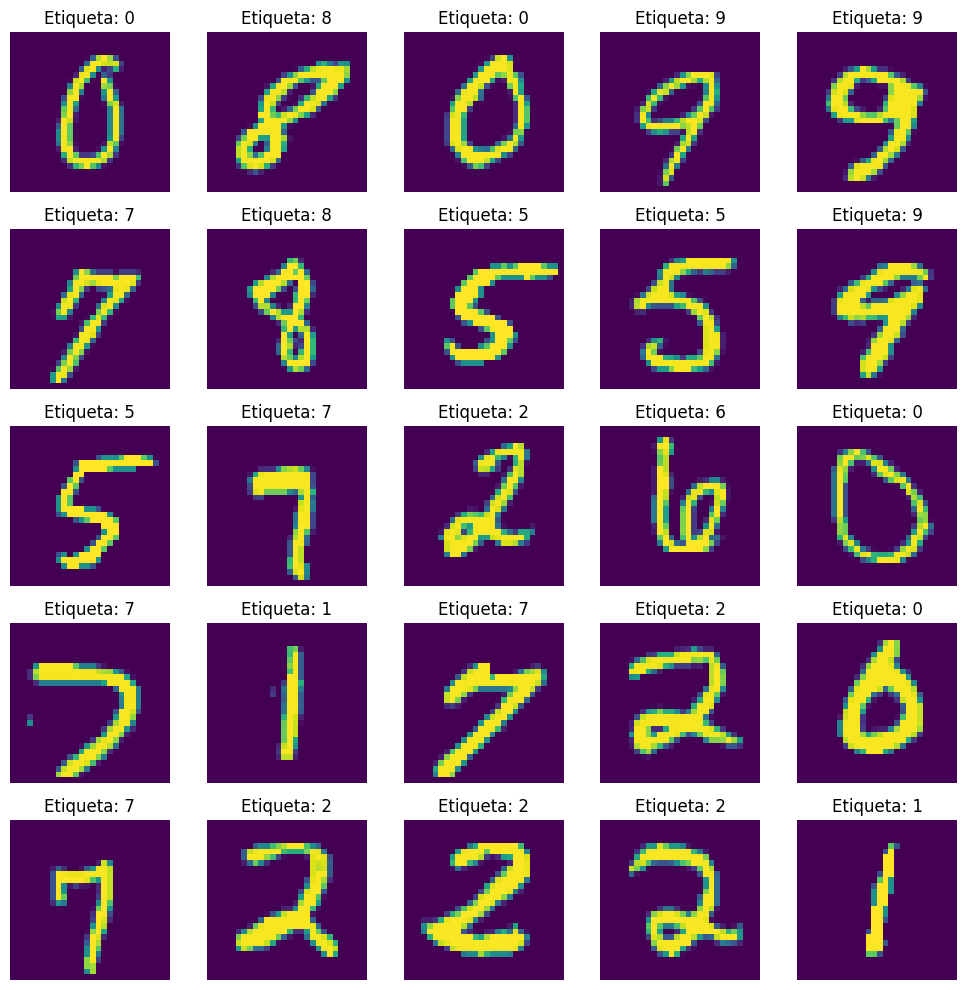

In [7]:
h = 5  # alto de la grilla
w = 5  # ancho de la grilla
fig, axs = plt.subplots(h, w, figsize=(2*w, 2*h))

for i in range(h):
    for j in range(w):
        ex = np.random.randint(len(X_test))
        axs[i, j].imshow(X_test[ex].reshape(28, 28))
        axs[i, j].set_title(f"Etiqueta: {np.argmax(y_test[ex])}")
        axs[i, j].axis('off')  # Oculta los ejes

plt.tight_layout()
plt.show()

# Definición del modelo (De momento voy a realizar todos los pasos aqui, despues ordeno, atte juan xoxo)

## Optimizador: SGD + Momentum

In [8]:
hist_models = []

In [9]:
M_train = X_train.shape[0]
M_test = X_test.shape[0]

N = X_train.shape[1]
C = y_train.shape[1]

print(N, C, M_train, M_test)

784 10 60000 10000


In [10]:
# Setea los seed para números random

np.random.seed(12)
tf.random.set_seed(12)


# Se crea la red feed-forward tiene 3 capas escondidas

h1 = 128
h2 = 64

red_sgd = keras.Sequential(name="MLP_sgd")
red_sgd.add(keras.layers.Dense(h1, input_dim=N, activation='relu', name='primera_capa'))
red_sgd.add(keras.layers.Dense(h2, activation='relu', name='segunda_capa'))
red_sgd.add(keras.layers.Dense(C, activation='softmax', name='capa_de_salida'))


red_sgd.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
    metrics=['accuracy', 'Precision', 'Recall', 'F1Score']
)

In [11]:
time_start = time.time()
hist_sgd = red_sgd.fit(X_train, y_train,
        epochs=10,
        batch_size=128,
        validation_data=(X_test,y_test)
        )
time_sgd = time.time() - time_start

hist_sgd.name = red_sgd.name
hist_models.append(hist_sgd)

red_sgd.save("red_sgd.keras")

Epoch 1/10
469/469 [==============================] - 3s 6ms/step - loss: 0.4902 - accuracy: 0.8604 - precision: 0.9340 - recall: 0.7839 - f1_score: 0.8577 - val_loss: 0.2377 - val_accuracy: 0.9310 - val_precision: 0.9496 - val_recall: 0.9169 - val_f1_score: 0.9300
Epoch 2/10
469/469 [==============================] - 2s 3ms/step - loss: 0.2145 - accuracy: 0.9382 - precision: 0.9531 - recall: 0.9248 - f1_score: 0.9375 - val_loss: 0.1763 - val_accuracy: 0.9473 - val_precision: 0.9595 - val_recall: 0.9379 - val_f1_score: 0.9468
Epoch 3/10
469/469 [==============================] - 2s 4ms/step - loss: 0.1625 - accuracy: 0.9524 - precision: 0.9635 - recall: 0.9436 - f1_score: 0.9519 - val_loss: 0.1427 - val_accuracy: 0.9589 - val_precision: 0.9652 - val_recall: 0.9522 - val_f1_score: 0.9585
Epoch 4/10
469/469 [==============================] - 2s 4ms/step - loss: 0.1312 - accuracy: 0.9621 - precision: 0.9693 - recall: 0.9550 - f1_score: 0.9617 - val_loss: 0.1172 - val_accuracy: 0.9643 - va

## Learning rate

In [12]:
# Setea los seed para números random

np.random.seed(12)
tf.random.set_seed(12)


# Se crea la red feed-forward tiene 2 capas escondidas

h1 = 128
h2 = 64

red_sgd_learn = keras.Sequential(name="MLP_sgd_l005")
red_sgd_learn.add(keras.layers.Dense(h1, input_dim=N, activation='relu', name='primera_capa'))
red_sgd_learn.add(keras.layers.Dense(h2, activation='relu', name='segunda_capa'))
red_sgd_learn.add(keras.layers.Dense(C, activation='softmax', name='capa_de_salida'))


red_sgd_learn.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.05, momentum=0.9),
    metrics=['accuracy', 'Precision', 'Recall', 'F1Score']
)

In [13]:
time_start = time.time()
hist_sgd_learn = red_sgd_learn.fit(X_train, y_train,
        epochs=10,
        batch_size=128,
        validation_data=(X_test,y_test)
        )
time_sgd_learn = time.time() - time_start

hist_sgd_learn.name = red_sgd_learn.name
hist_models.append(hist_sgd_learn)

red_sgd_learn.save("red_sgd_l005.keras")

Epoch 1/10
469/469 [==============================] - 3s 5ms/step - loss: 0.2956 - accuracy: 0.9109 - precision: 0.9425 - recall: 0.8831 - f1_score: 0.9097 - val_loss: 0.1297 - val_accuracy: 0.9607 - val_precision: 0.9675 - val_recall: 0.9542 - val_f1_score: 0.9604
Epoch 2/10
469/469 [==============================] - 2s 3ms/step - loss: 0.1202 - accuracy: 0.9632 - precision: 0.9692 - recall: 0.9581 - f1_score: 0.9629 - val_loss: 0.1173 - val_accuracy: 0.9627 - val_precision: 0.9687 - val_recall: 0.9580 - val_f1_score: 0.9625
Epoch 3/10
469/469 [==============================] - 2s 4ms/step - loss: 0.0861 - accuracy: 0.9732 - precision: 0.9771 - recall: 0.9697 - f1_score: 0.9730 - val_loss: 0.0972 - val_accuracy: 0.9706 - val_precision: 0.9737 - val_recall: 0.9680 - val_f1_score: 0.9705
Epoch 4/10
469/469 [==============================] - 2s 4ms/step - loss: 0.0632 - accuracy: 0.9801 - precision: 0.9825 - recall: 0.9777 - f1_score: 0.9799 - val_loss: 0.0818 - val_accuracy: 0.9746 - va

## Aumento de capas

In [14]:
# Setea los seed para números random

np.random.seed(12)
tf.random.set_seed(12)


# Se crea la red feed-forward tiene 4 capas escondidas

h1 = 128
h2 = 64

red_sgd_learn_layers = keras.Sequential(name="MLP_sgd_l005_c4")
red_sgd_learn_layers.add(keras.layers.Dense(h1, input_dim=N, activation='relu', name='primera_capa'))
red_sgd_learn_layers.add(keras.layers.Dense(h2, activation='relu', name='segunda_capa'))
red_sgd_learn_layers.add(keras.layers.Dense(h2, activation='relu', name='tercera_capa'))
red_sgd_learn_layers.add(keras.layers.Dense(h2, activation='relu', name='cuarta_capa'))
red_sgd_learn_layers.add(keras.layers.Dense(C, activation='softmax', name='capa_de_salida'))


red_sgd_learn_layers.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.05, momentum=0.9),
    metrics=['accuracy', 'Precision', 'Recall', 'F1Score']
)

In [15]:
time_start = time.time()
hist_sgd_learn_layers = red_sgd_learn_layers.fit(X_train, y_train,
        epochs=10,
        batch_size=128,
        validation_data=(X_test,y_test)
        )
time_sgd_learn_layers = time.time() - time_start

hist_sgd_learn_layers.name = red_sgd_learn_layers.name
hist_models.append(hist_sgd_learn_layers)

red_sgd_learn_layers.save("red_sgd_l005_c4.keras")

Epoch 1/10
469/469 [==============================] - 3s 4ms/step - loss: 0.3311 - accuracy: 0.9002 - precision: 0.9385 - recall: 0.8685 - f1_score: 0.8991 - val_loss: 0.1273 - val_accuracy: 0.9606 - val_precision: 0.9681 - val_recall: 0.9554 - val_f1_score: 0.9602
Epoch 2/10
469/469 [==============================] - 2s 4ms/step - loss: 0.1226 - accuracy: 0.9631 - precision: 0.9691 - recall: 0.9577 - f1_score: 0.9627 - val_loss: 0.1146 - val_accuracy: 0.9667 - val_precision: 0.9717 - val_recall: 0.9623 - val_f1_score: 0.9663
Epoch 3/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0890 - accuracy: 0.9723 - precision: 0.9762 - recall: 0.9691 - f1_score: 0.9721 - val_loss: 0.0991 - val_accuracy: 0.9711 - val_precision: 0.9740 - val_recall: 0.9682 - val_f1_score: 0.9708
Epoch 4/10
469/469 [==============================] - 2s 4ms/step - loss: 0.0661 - accuracy: 0.9798 - precision: 0.9826 - recall: 0.9775 - f1_score: 0.9797 - val_loss: 0.0892 - val_accuracy: 0.9738 - va

## Funciones de activacion

In [16]:
# Setea los seed para números random

np.random.seed(12)
tf.random.set_seed(12)


# Se crea la red feed-forward tiene 2 capas escondidas

h1 = 128
h2 = 64

red_sgd_learn_act = keras.Sequential(name="MLP_sgd_l0.05_actTanh")
red_sgd_learn_act.add(keras.layers.Dense(h1, input_dim=N, activation='tanh', name='primera_capa'))
red_sgd_learn_act.add(keras.layers.Dense(h2, activation='tanh', name='segunda_capa'))
red_sgd_learn_act.add(keras.layers.Dense(C, activation='softmax', name='capa_de_salida'))


red_sgd_learn_act.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.05, momentum=0.9),
    metrics=['accuracy', 'Precision', 'Recall', 'F1Score']
)

In [17]:
time_start = time.time()
hist_sgd_learn_act = red_sgd_learn_act.fit(X_train, y_train,
        epochs=10,
        batch_size=128,
        validation_data=(X_test,y_test)
        )
time_sgd_learn_act = time.time() - time_start

hist_sgd_learn_act.name = red_sgd_learn_act.name
hist_models.append(hist_sgd_learn_act)

red_sgd_learn_act.save("red_sgd_l005_actTanh.keras")

Epoch 1/10
469/469 [==============================] - 2s 4ms/step - loss: 0.3022 - accuracy: 0.9095 - precision: 0.9409 - recall: 0.8825 - f1_score: 0.9083 - val_loss: 0.1678 - val_accuracy: 0.9519 - val_precision: 0.9609 - val_recall: 0.9406 - val_f1_score: 0.9514
Epoch 2/10
469/469 [==============================] - 2s 4ms/step - loss: 0.1385 - accuracy: 0.9582 - precision: 0.9667 - recall: 0.9514 - f1_score: 0.9578 - val_loss: 0.1266 - val_accuracy: 0.9617 - val_precision: 0.9678 - val_recall: 0.9572 - val_f1_score: 0.9614
Epoch 3/10
469/469 [==============================] - 2s 4ms/step - loss: 0.0971 - accuracy: 0.9708 - precision: 0.9763 - recall: 0.9665 - f1_score: 0.9706 - val_loss: 0.1076 - val_accuracy: 0.9671 - val_precision: 0.9723 - val_recall: 0.9617 - val_f1_score: 0.9668
Epoch 4/10
469/469 [==============================] - 2s 4ms/step - loss: 0.0750 - accuracy: 0.9772 - precision: 0.9808 - recall: 0.9742 - f1_score: 0.9770 - val_loss: 0.0871 - val_accuracy: 0.9738 - va

## Tamaño de batch

In [18]:
# Setea los seed para números random

np.random.seed(12)
tf.random.set_seed(12)


# Se crea la red feed-forward tiene 2 capas escondidas

h1 = 128
h2 = 64

red_sgd_learn_act_batch = keras.Sequential(name="MLP_sgd_l0.05_actTanh_batch32")
red_sgd_learn_act_batch.add(keras.layers.Dense(h1, input_dim=N, activation='tanh', name='primera_capa'))
red_sgd_learn_act_batch.add(keras.layers.Dense(h2, activation='tanh', name='segunda_capa'))
red_sgd_learn_act_batch.add(keras.layers.Dense(C, activation='softmax', name='capa_de_salida'))


red_sgd_learn_act_batch.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.05, momentum=0.9),
    metrics=['accuracy', 'Precision', 'Recall', 'F1Score']
)

In [19]:
time_start = time.time()
hist_sgd_learn_act_batch = red_sgd_learn_act_batch.fit(X_train, y_train,
        epochs=10,
        batch_size=32,
        validation_data=(X_test,y_test)
        )
time_sgd_learn_act_batch = time.time() - time_start

hist_sgd_learn_act_batch.name = red_sgd_learn_act_batch.name
hist_models.append(hist_sgd_learn_act_batch)

red_sgd_learn_act_batch.save("red_sgd_l005_actTanh_batch32.keras")

Epoch 1/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2370 - accuracy: 0.9276 - precision: 0.9438 - recall: 0.9155 - f1_score: 0.9267 - val_loss: 0.1531 - val_accuracy: 0.9535 - val_precision: 0.9599 - val_recall: 0.9478 - val_f1_score: 0.9532
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1224 - accuracy: 0.9627 - precision: 0.9679 - recall: 0.9588 - f1_score: 0.9624 - val_loss: 0.1087 - val_accuracy: 0.9671 - val_precision: 0.9713 - val_recall: 0.9645 - val_f1_score: 0.9669
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0917 - accuracy: 0.9716 - precision: 0.9748 - recall: 0.9693 - f1_score: 0.9714 - val_loss: 0.1216 - val_accuracy: 0.9649 - val_precision: 0.9687 - val_recall: 0.9615 - val_f1_score: 0.9645
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0751 - accuracy: 0.9762 - precision: 0.9787 - recall: 0.9742 - f1_score: 0.9760 - val_loss: 0.1090 - val_accuracy: 0.9

## Dropout

In [20]:
# Setea los seed para números random

np.random.seed(12)
tf.random.set_seed(12)


# Se crea la red feed-forward tiene 2 capas escondidas

h1 = 128
h2 = 64

red_sgd_learn_act_drop = keras.Sequential(name="MLP_sgd_l0.05_actTanh_drop0.3")
red_sgd_learn_act_drop.add(keras.layers.Dense(h1, input_dim=N, activation='tanh', name='primera_capa'))
red_sgd_learn_act_drop.add(keras.layers.Dropout(0.3))
red_sgd_learn_act_drop.add(keras.layers.Dense(h2, activation='tanh', name='segunda_capa'))
red_sgd_learn_act_drop.add(keras.layers.Dense(C, activation='softmax', name='capa_de_salida'))


red_sgd_learn_act_drop.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.05, momentum=0.9),
    metrics=['accuracy', 'Precision', 'Recall', 'F1Score']
)

In [21]:
time_start = time.time()
hist_sgd_learn_act_drop = red_sgd_learn_act_drop.fit(X_train, y_train,
        epochs=10,
        batch_size=128,
        validation_data=(X_test,y_test)
        )
time_sgd_learn_act_drop = time.time() - time_start

hist_sgd_learn_act_drop.name = red_sgd_learn_act_drop.name
hist_models.append(hist_sgd_learn_act_drop)

red_sgd_learn_act_drop.save("red_sgd_l005_actTanh_drop0.3.keras")

Epoch 1/10
469/469 [==============================] - 3s 4ms/step - loss: 0.3545 - accuracy: 0.8924 - precision: 0.9273 - recall: 0.8634 - f1_score: 0.8909 - val_loss: 0.1814 - val_accuracy: 0.9451 - val_precision: 0.9556 - val_recall: 0.9362 - val_f1_score: 0.9445
Epoch 2/10
469/469 [==============================] - 2s 4ms/step - loss: 0.1953 - accuracy: 0.9411 - precision: 0.9533 - recall: 0.9316 - f1_score: 0.9405 - val_loss: 0.1413 - val_accuracy: 0.9562 - val_precision: 0.9640 - val_recall: 0.9503 - val_f1_score: 0.9557
Epoch 3/10
469/469 [==============================] - 2s 4ms/step - loss: 0.1578 - accuracy: 0.9520 - precision: 0.9611 - recall: 0.9444 - f1_score: 0.9515 - val_loss: 0.1259 - val_accuracy: 0.9625 - val_precision: 0.9676 - val_recall: 0.9576 - val_f1_score: 0.9620
Epoch 4/10
469/469 [==============================] - 2s 4ms/step - loss: 0.1374 - accuracy: 0.9583 - precision: 0.9660 - recall: 0.9522 - f1_score: 0.9579 - val_loss: 0.1074 - val_accuracy: 0.9643 - va

## Tabla con métricas de cada modelo

In [22]:
results = []

for hist in hist_models:
    final_epoch = {}
    for metric, values in hist.history.items():
        final_epoch[metric] = values[-1]
    results.append({"Modelo": hist.name, **final_epoch})

results_df = pd.DataFrame(results)
results_df

,Modelo,loss,accuracy,precision,recall,f1_score,val_loss,val_accuracy,val_precision,val_recall,val_f1_score
0,MLP_sgd,0.054561,0.984350,0.986962,0.981583,"[0.9907267, 0.98962504, 0.9839806, 0.97961855,...",0.079628,0.9753,0.979068,0.9729,"[0.9807887, 0.9872528, 0.9761092, 0.9742829, 0..."
1,MLP_sgd_l005,0.017423,0.994250,0.994829,0.993933,"[0.9966262, 0.9956254, 0.9947978, 0.993144, 0....",0.083534,0.9760,0.977059,0.9753,"[0.9877676, 0.9868766, 0.97672164, 0.97351325,..."
2,MLP_sgd_l005_c4,0.025554,0.991733,0.992490,0.991233,"[0.9952759, 0.99414426, 0.9905146, 0.9887402, ...",0.090207,0.9769,0.978346,0.9759,"[0.9847561, 0.98473614, 0.97909576, 0.97458893..."
3,MLP_sgd_l0.05_actTanh,0.019685,0.994617,0.995360,0.993850,"[0.996961, 0.9955516, 0.9947179, 0.99404126, 0...",0.072897,0.9778,0.980219,0.9762,"[0.9832911, 0.98902065, 0.9763855, 0.97180265,..."
4,MLP_sgd_l0.05_actTanh_batch32,0.035298,0.988467,0.989596,0.987617,"[0.9935005, 0.9936231, 0.9870827, 0.98612016, ...",0.101444,0.9745,0.976327,0.9733,"[0.9832061, 0.9889916, 0.97599214, 0.9645669, ..."
5,MLP_sgd_l0.05_actTanh_drop0.3,0.086249,0.972633,0.976893,0.969550,"[0.984984, 0.9850171, 0.9694682, 0.96541005, 0...",0.086032,0.9757,0.978077,0.9726,"[0.9827586, 0.9877085, 0.9745845, 0.97539365, ..."


# Optimizador: ADAM

## Creación modelo base

In [23]:
# Setea los seed para números random

np.random.seed(12)
tf.random.set_seed(12)


# Se crea la red feed-forward (tiene 2 capas escondidas!)

h1 = 128
h2 = 64

red_adam = keras.Sequential(name="MLP_adam")
red_adam.add(keras.layers.Dense(h1, input_dim=N, activation='relu', name='primera_capa'))
red_adam.add(keras.layers.Dense(h2, activation='relu', name='segunda_capa'))
red_adam.add(keras.layers.Dense(C, activation='softmax', name='capa_de_salida'))


red_adam.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy', 'Precision', 'Recall', 'F1Score']
)

In [24]:
hist_adam = red_adam.fit(X_train, y_train,
        epochs=10,
        batch_size=128,
        validation_data=(X_test,y_test)
        )

red_adam.save("red_adam.keras")

Epoch 1/10
469/469 [==============================] - 3s 5ms/step - loss: 0.3354 - accuracy: 0.9043 - precision: 0.9462 - recall: 0.8581 - f1_score: 0.9030 - val_loss: 0.1574 - val_accuracy: 0.9543 - val_precision: 0.9639 - val_recall: 0.9444 - val_f1_score: 0.9539
Epoch 2/10
469/469 [==============================] - 2s 5ms/step - loss: 0.1405 - accuracy: 0.9583 - precision: 0.9669 - recall: 0.9514 - f1_score: 0.9579 - val_loss: 0.1278 - val_accuracy: 0.9626 - val_precision: 0.9684 - val_recall: 0.9568 - val_f1_score: 0.9623
Epoch 3/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0996 - accuracy: 0.9708 - precision: 0.9760 - recall: 0.9657 - f1_score: 0.9706 - val_loss: 0.1036 - val_accuracy: 0.9683 - val_precision: 0.9728 - val_recall: 0.9645 - val_f1_score: 0.9680
Epoch 4/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0755 - accuracy: 0.9770 - precision: 0.9809 - recall: 0.9735 - f1_score: 0.9769 - val_loss: 0.0876 - val_accuracy: 0.9739 - va

## Learning rate

In [25]:
# Setea los seed para números random

np.random.seed(12)
tf.random.set_seed(12)


# Se crea la red feed-forward (tiene 3 capas escondidas!)

h1 = 128
h2 = 64

red_adam_learn = keras.Sequential(name="MLP_adam")
red_adam_learn.add(keras.layers.Dense(h1, input_dim=N, activation='relu', name='primera_capa'))
red_adam_learn.add(keras.layers.Dense(h2, activation='relu', name='segunda_capa'))
red_adam_learn.add(keras.layers.Dense(C, activation='softmax', name='capa_de_salida'))


red_adam_learn.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics=['accuracy', 'Precision', 'Recall', 'F1Score']
)

In [26]:
hist_adam = red_adam_learn.fit(X_train, y_train,
        epochs=10,
        batch_size=128,
        validation_data=(X_test,y_test)
        )

red_adam_learn.save("red_adam_learn.keras")

Epoch 1/10
469/469 [==============================] - 3s 5ms/step - loss: 0.2283 - accuracy: 0.9302 - precision: 0.9483 - recall: 0.9169 - f1_score: 0.9295 - val_loss: 0.1300 - val_accuracy: 0.9633 - val_precision: 0.9701 - val_recall: 0.9580 - val_f1_score: 0.9630
Epoch 2/10
469/469 [==============================] - 2s 4ms/step - loss: 0.1206 - accuracy: 0.9635 - precision: 0.9691 - recall: 0.9594 - f1_score: 0.9632 - val_loss: 0.1294 - val_accuracy: 0.9609 - val_precision: 0.9679 - val_recall: 0.9559 - val_f1_score: 0.9604
Epoch 3/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0977 - accuracy: 0.9705 - precision: 0.9754 - recall: 0.9670 - f1_score: 0.9702 - val_loss: 0.1372 - val_accuracy: 0.9628 - val_precision: 0.9669 - val_recall: 0.9599 - val_f1_score: 0.9625
Epoch 4/10
469/469 [==============================] - 3s 7ms/step - loss: 0.0879 - accuracy: 0.9733 - precision: 0.9769 - recall: 0.9707 - f1_score: 0.9730 - val_loss: 0.1058 - val_accuracy: 0.9714 - va

## Aumento de capas

In [27]:
# Setea los seed para números random

np.random.seed(12)
tf.random.set_seed(12)


# Se crea la red feed-forward (tiene 3 capas escondidas!)

h1 = 128
h2 = 64

red_adam_layers = keras.Sequential(name="MLP_adam")
red_adam_layers.add(keras.layers.Dense(h1, input_dim=N, activation='relu', name='primera_capa'))
red_adam_layers.add(keras.layers.Dense(h2, activation='relu', name='segunda_capa'))
red_adam_layers.add(keras.layers.Dense(h2, activation='relu', name='tercera_capa'))
red_adam_layers.add(keras.layers.Dense(h2, activation='relu', name='cuarta_capa'))
red_adam_layers.add(keras.layers.Dense(C, activation='softmax', name='capa_de_salida'))


red_adam_layers.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy', 'Precision', 'Recall', 'F1Score']
)

In [28]:
hist_adam = red_adam_layers.fit(X_train, y_train,
        epochs=10,
        batch_size=128,
        validation_data=(X_test,y_test)
        )

red_adam_layers.save("red_adam_layers.keras")

Epoch 1/10
469/469 [==============================] - 7s 10ms/step - loss: 0.3465 - accuracy: 0.8947 - precision: 0.9431 - recall: 0.8548 - f1_score: 0.8940 - val_loss: 0.1455 - val_accuracy: 0.9565 - val_precision: 0.9652 - val_recall: 0.9491 - val_f1_score: 0.9560
Epoch 2/10
469/469 [==============================] - 4s 9ms/step - loss: 0.1256 - accuracy: 0.9621 - precision: 0.9692 - recall: 0.9563 - f1_score: 0.9617 - val_loss: 0.1242 - val_accuracy: 0.9622 - val_precision: 0.9686 - val_recall: 0.9575 - val_f1_score: 0.9619
Epoch 3/10
469/469 [==============================] - 4s 8ms/step - loss: 0.0870 - accuracy: 0.9728 - precision: 0.9770 - recall: 0.9695 - f1_score: 0.9725 - val_loss: 0.1097 - val_accuracy: 0.9654 - val_precision: 0.9700 - val_recall: 0.9622 - val_f1_score: 0.9651
Epoch 4/10
469/469 [==============================] - 4s 8ms/step - loss: 0.0660 - accuracy: 0.9799 - precision: 0.9829 - recall: 0.9771 - f1_score: 0.9797 - val_loss: 0.0788 - val_accuracy: 0.9754 - v

## Funciones de activación

In [29]:


# Setea los seed para números random

np.random.seed(12)
tf.random.set_seed(12)


# Se crea la red feed-forward (tiene 3 capas escondidas!)

h1 = 128
h2 = 64

red_adam_act = keras.Sequential(name="MLP_adam")
red_adam_act.add(keras.layers.Dense(h1, input_dim=N, activation='tanh', name='primera_capa'))
red_adam_act.add(keras.layers.Dense(h2, activation='tanh', name='segunda_capa'))
red_adam_act.add(keras.layers.Dense(C, activation='softmax', name='capa_de_salida'))


red_adam_act.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics=['accuracy', 'Precision', 'Recall', 'F1Score']
)

In [30]:
hist_adam = red_adam_act.fit(X_train, y_train,
        epochs=10,
        batch_size=128,
        validation_data=(X_test,y_test)
        )

red_adam_act.save("red_adam_act.keras")

Epoch 1/10
469/469 [==============================] - 4s 6ms/step - loss: 0.2517 - accuracy: 0.9234 - precision: 0.9427 - recall: 0.9091 - f1_score: 0.9226 - val_loss: 0.1579 - val_accuracy: 0.9545 - val_precision: 0.9609 - val_recall: 0.9482 - val_f1_score: 0.9541
Epoch 2/10
469/469 [==============================] - 2s 5ms/step - loss: 0.1456 - accuracy: 0.9558 - precision: 0.9623 - recall: 0.9506 - f1_score: 0.9553 - val_loss: 0.1537 - val_accuracy: 0.9551 - val_precision: 0.9610 - val_recall: 0.9504 - val_f1_score: 0.9547
Epoch 3/10
469/469 [==============================] - 2s 5ms/step - loss: 0.1300 - accuracy: 0.9593 - precision: 0.9651 - recall: 0.9552 - f1_score: 0.9590 - val_loss: 0.1598 - val_accuracy: 0.9500 - val_precision: 0.9582 - val_recall: 0.9456 - val_f1_score: 0.9496
Epoch 4/10
469/469 [==============================] - 3s 5ms/step - loss: 0.1264 - accuracy: 0.9614 - precision: 0.9665 - recall: 0.9578 - f1_score: 0.9610 - val_loss: 0.1345 - val_accuracy: 0.9603 - va

## Tamaño del batch

In [31]:
# Setea los seed para números random

np.random.seed(12)
tf.random.set_seed(12)


# Se crea la red feed-forward (tiene 3 capas escondidas!)

h1 = 128
h2 = 64

red_adam_batch = keras.Sequential(name="MLP_adam")
red_adam_batch.add(keras.layers.Dense(h1, input_dim=N, activation='relu', name='primera_capa'))
red_adam_batch.add(keras.layers.Dense(h2, activation='relu', name='segunda_capa'))
red_adam_batch.add(keras.layers.Dense(C, activation='softmax', name='capa_de_salida'))


red_adam_batch.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy', 'Precision', 'Recall', 'F1Score']
)

In [32]:
hist_adam = red_adam_batch.fit(X_train, y_train,
        epochs=10,
        batch_size=32,
        validation_data=(X_test,y_test)
        )


red_adam_batch.save("red_adam_batch.keras")


Epoch 1/10
1875/1875 [==============================] - 13s 6ms/step - loss: 0.2411 - accuracy: 0.9295 - precision: 0.9531 - recall: 0.9059 - f1_score: 0.9287 - val_loss: 0.1053 - val_accuracy: 0.9682 - val_precision: 0.9732 - val_recall: 0.9628 - val_f1_score: 0.9680
Epoch 2/10
1875/1875 [==============================] - 12s 7ms/step - loss: 0.1014 - accuracy: 0.9686 - precision: 0.9735 - recall: 0.9645 - f1_score: 0.9683 - val_loss: 0.0874 - val_accuracy: 0.9737 - val_precision: 0.9776 - val_recall: 0.9708 - val_f1_score: 0.9735
Epoch 3/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0712 - accuracy: 0.9775 - precision: 0.9805 - recall: 0.9750 - f1_score: 0.9773 - val_loss: 0.0834 - val_accuracy: 0.9738 - val_precision: 0.9779 - val_recall: 0.9717 - val_f1_score: 0.9736
Epoch 4/10
1875/1875 [==============================] - 10s 6ms/step - loss: 0.0537 - accuracy: 0.9828 - precision: 0.9849 - recall: 0.9809 - f1_score: 0.9827 - val_loss: 0.0810 - val_accuracy:

## Dropout

In [33]:
# Setea los seed para números random

np.random.seed(12)
tf.random.set_seed(12)


# Se crea la red feed-forward (tiene 2 capas escondidas!)

h1 = 128
h2 = 64

red_adam_drop = keras.Sequential(name="MLP_adam")
red_adam_drop.add(keras.layers.Dense(h1, input_dim=N, activation='relu', name='primera_capa'))
red_adam_drop.add(keras.layers.Dropout(0.2))
red_adam_drop.add(keras.layers.Dense(h2, activation='relu', name='segunda_capa'))
red_adam_drop.add(keras.layers.Dropout(0.2))
red_adam_drop.add(keras.layers.Dense(C, activation='softmax', name='capa_de_salida'))


red_adam_drop.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy', 'Precision', 'Recall', 'F1Score']
)

Justificación de las configuraciones utilizadas.

In [34]:
hist_adam = red_adam_drop.fit(X_train, y_train,
        epochs=10,
        batch_size=128,
        validation_data=(X_test,y_test)
        )


red_adam_drop.save("red_adam_drop.keras")

Epoch 1/10
469/469 [==============================] - 4s 6ms/step - loss: 0.4450 - accuracy: 0.8650 - precision: 0.9274 - recall: 0.8096 - f1_score: 0.8631 - val_loss: 0.1677 - val_accuracy: 0.9497 - val_precision: 0.9610 - val_recall: 0.9397 - val_f1_score: 0.9490
Epoch 2/10
469/469 [==============================] - 2s 5ms/step - loss: 0.1946 - accuracy: 0.9426 - precision: 0.9565 - recall: 0.9300 - f1_score: 0.9420 - val_loss: 0.1222 - val_accuracy: 0.9625 - val_precision: 0.9689 - val_recall: 0.9565 - val_f1_score: 0.9622
Epoch 3/10
469/469 [==============================] - 2s 5ms/step - loss: 0.1489 - accuracy: 0.9558 - precision: 0.9662 - recall: 0.9467 - f1_score: 0.9554 - val_loss: 0.1091 - val_accuracy: 0.9664 - val_precision: 0.9711 - val_recall: 0.9613 - val_f1_score: 0.9662
Epoch 4/10
469/469 [==============================] - 3s 6ms/step - loss: 0.1235 - accuracy: 0.9630 - precision: 0.9694 - recall: 0.9568 - f1_score: 0.9627 - val_loss: 0.0901 - val_accuracy: 0.9708 - va

# Evaluación del modelo:

Uso de métricas como accuracy, precision, recall y F1-score.

# Optimizador: SGD + Momentum

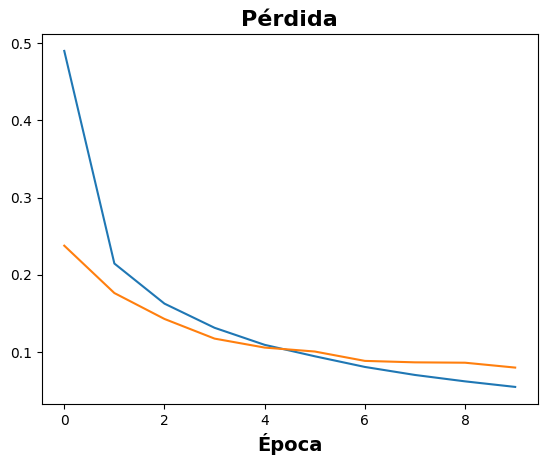

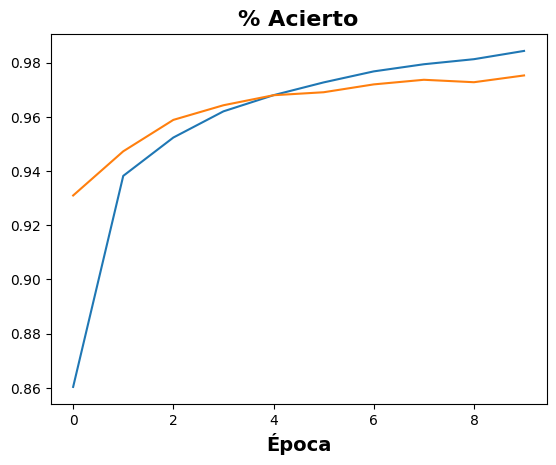

In [35]:
plt.plot(hist_sgd.history['loss'])
plt.plot(hist_sgd.history['val_loss'])
plt.title('Pérdida', fontweight="bold", fontsize=16)
plt.xlabel('Época', fontweight="bold", fontsize=14)
plt.show()

plt.plot(hist_sgd.history['accuracy'])
plt.plot(hist_sgd.history['val_accuracy'])
plt.title('% Acierto', fontweight="bold", fontsize=16)
plt.xlabel('Época', fontweight="bold", fontsize=14)
plt.show()

# Análisis y mejora del modelo:

Comparación de distintas configuraciones y ajustes realizados.

# Conclusiones:

Reflexión sobre el desempeño del modelo y posibles mejoras.

In [38]:
# To avoid issues with loaded_model, let's ensure to load the model correctly and test it with the provided data.

from tensorflow.keras.models import load_model

# Load the model
loaded_model = load_model('red_sgd_l005_actTanh.keras', compile=True)

# Evaluate the loaded model on the test data
results = loaded_model.evaluate(X_test, y_test)

# Print the results
print("Test results:")
for metric_name, result in zip(loaded_model.metrics_names, results):
    print(f"{metric_name}: {result}")

IndexError: tuple index out of range

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9dc7e3b2-3914-4a2d-83b3-47dbec5af292' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>